# IMPORTS

In [1]:
import re
import holidays
from collections import Counter
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import classification_report,plot_confusion_matrix, accuracy_score
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

# Inclusão dos tipos de estradas menos ocorrentes (IC e EM)

Apenas alteramos a função de tratamento do affected roads, porque só estávamos a ter em conta os tipos R e N. Agora, temos em conta todos os tipos, é mais preciso.

In [2]:
# leitura
incidentes = pd.read_csv('../input/training_data.csv')
teste = pd.read_csv('../input/test_data.csv')

In [3]:
# remoção de colunas desnecessárias
incidentes=incidentes.drop(['city_name'],axis=1)
incidentes=incidentes.drop(['avg_precipitation'],axis=1)
teste=teste.drop(['city_name'],axis=1)
teste=teste.drop(['avg_precipitation'],axis=1)

In [4]:
# transformação para numéricas
incidentes["avg_rain"] = incidentes['avg_rain'].replace({'Sem Chuva' : 0, 'chuva fraca' : 1, 'chuva moderada' : 2, 'chuva forte' : 3}).astype(int)
incidentes["magnitude_of_delay"] = incidentes['magnitude_of_delay'].replace({'UNDEFINED' : 0, 'MODERATE' : 1, 'MAJOR' : 2}).astype(int)
incidentes['luminosity'] = incidentes['luminosity'].replace(['DARK','LOW_LIGHT','LIGHT'],[0,1,2]).astype(int)
incidentes['record_date'] = pd.to_datetime(incidentes['record_date'])
incidentes["incidents"] = incidentes['incidents'].replace({'None' : 0, 'Low' : 1, 'Medium' : 2, 'High' : 3, 'Very_High' : 4}).astype(int)

teste["avg_rain"] = teste['avg_rain'].replace({'Sem Chuva' : 0, 'chuva fraca' : 1, 'chuva moderada' : 2, 'chuva forte' : 3}).astype(int)
teste["magnitude_of_delay"] = teste['magnitude_of_delay'].replace({'UNDEFINED' : 0, 'MODERATE' : 1, 'MAJOR' : 2}).astype(int)
teste['luminosity'] = teste['luminosity'].replace(['DARK','LOW_LIGHT','LIGHT'],[0,1,2]).astype(int)

#### Método diferente para tratar as estradas afetadas com IC e EM agora incluídos

In [5]:
# MÉTODO 2
# create the two new columns
incidentes["National"] = 0
incidentes["Regional"] = 0
incidentes["IC"] = 0
incidentes["EM"] = 0

def treat_affected_roads_types(df):
    # Check if the value in the "affected_roads" column is null, empty, or equal to ","
    mask = df["affected_roads"].isnull() | df["affected_roads"].eq("") | df["affected_roads"].eq(",")
    df.loc[mask, "National"] = 0
    df.loc[mask, "Regional"] = 0
    df.loc[mask, "IC"] = 0
    df.loc[mask, "EM"] = 0
    
    # For the remaining rows, split the string in the "affected_roads" column by comma and count the occurances of each road type
    for index, row in df[~mask].iterrows():
        # Create a Counter object to store the counts of each road type
        road_counts = Counter({"N": 0, "R": 0, "IC": 0, "EM": 0})
        
        # Split the string and update the counts in the Counter object
        roads = row["affected_roads"].split(",")
        for road in roads:
            # Use a regular expression to extract the road type
            road_type = re.search("^(N|R|IC|EM)\d+", road)
            if road_type:
                road_type = road_type.group()[0]
                road_counts[road_type] += 1
        
        # Set the values in the new columns
        df.loc[index, "National"] = road_counts["N"]
        df.loc[index, "Regional"] = road_counts["R"]
        df.loc[index, "IC"] = road_counts["IC"]
        df.loc[index, "EM"] = road_counts["EM"]
        
    return df

In [6]:
incidentes = treat_affected_roads_types(incidentes)
teste = treat_affected_roads_types(teste)

In [7]:
# remover a coluna tratada
incidentes=incidentes.drop(['affected_roads'],axis=1)
teste=teste.drop(['affected_roads'],axis=1)

In [8]:
# tratar o record_time
# treino
incidentes['record_date'] = pd.to_datetime(incidentes['record_date'])
incidentes['day_of_month'] = incidentes['record_date'].dt.day
incidentes['week_day'] = incidentes['record_date'].dt.weekday
incidentes['month'] = incidentes['record_date'].dt.month
incidentes['year'] = incidentes['record_date'].dt.year
incidentes['hour'] = incidentes['record_date'].dt.hour
incidentes['minute'] = incidentes['record_date'].dt.minute
incidentes['day_of_year'] = incidentes['record_date'].dt.dayofyear

# teste
teste['record_date'] = pd.to_datetime(teste['record_date'])
teste['day_of_month'] = teste['record_date'].dt.day
teste['week_day'] = teste['record_date'].dt.weekday
teste['month'] = teste['record_date'].dt.month
teste['year'] = teste['record_date'].dt.year
teste['hour'] = teste['record_date'].dt.hour
teste['minute'] = teste['record_date'].dt.minute
teste['day_of_year'] = teste['record_date'].dt.dayofyear


In [9]:
# remover essa coluna
incidentes.drop('minute', axis=1, inplace=True)
incidentes.drop('year', axis=1, inplace=True)
teste.drop('minute', axis=1, inplace=True)
teste.drop('year', axis=1, inplace=True)


* Vamos extrair algumas features que podem ter interesse:
    * Estação do Ano;
    * Fim de semana;
    * Feriado;
* A ideia é depois relacionar com as métricas e verificar se o modelo melhorou

In [10]:
# obter estação do ano para cada dia
def get_season(df):
    seasons = []
    for index, row in df.iterrows():
        # Access the data in each column by column name
        month = row['month']
        day = row['day_of_month']
    
        # Determine the season based on the month and day of the month
        if month in [3, 4, 5]:
            # For March, April, and May, use the day to determine the season
            if day < 21:
                season = 0
            else:
                season = 1
        elif month in [6, 7, 8]:
            season = 1
        elif month in [9, 10, 11]:
            # For September, October, and November, use the day to determine the season
            if day < 21:
                season = 2
            else:
                season = 3
        else:
            season = 3
        seasons.append(season)
    return seasons

In [11]:
incidentes['season'] = get_season(incidentes)
teste['season'] = get_season(teste)

In [12]:
# determina se é ou não um dia de férias
def is_holidays(df):
    pt_holidays = holidays.CountryHoliday("PT")
    df["is_holiday"] = 0

    for i, row in df.iterrows():
        date_field = row["record_date"]
        if date_field in pt_holidays:
            df.at[i, "is_holiday"] = 1
    return df

In [13]:
incidentes = is_holidays(incidentes)
teste = is_holidays(teste)

In [14]:
# determina se é fim de semana ou não
def is_weekend(df):
    df["is_weekend"] = 0
    for i, row in df.iterrows():
        date_field = row["week_day"]
        if date_field in [0, 4]:
            df["is_weekend"] = 1
    return df

In [15]:
incidentes = is_weekend(incidentes)
teste = is_weekend(teste)

In [16]:
# podemos remover a coluna
incidentes.drop('record_date', axis=1, inplace=True)
# podemos remover a coluna
teste.drop('record_date', axis=1, inplace=True)

In [17]:
incidentes.head()

,magnitude_of_delay,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,National,...,IC,EM,day_of_month,week_day,month,hour,day_of_year,season,is_holiday,is_weekend
0,0,0,0,12.0,1013.0,70.0,1.0,0,0,0,...,0,0,15,0,3,23,74,0,0,1
1,0,385,0,12.0,1007.0,91.0,1.0,0,0,1,...,0,0,25,5,12,18,359,3,1,1
2,0,69,2,14.0,1025.0,64.0,0.0,0,1,0,...,0,0,12,4,3,15,71,0,0,1
3,2,2297,2,15.0,1028.0,75.0,1.0,0,4,10,...,0,0,29,2,9,9,272,3,0,1
4,0,0,2,27.0,1020.0,52.0,1.0,0,3,5,...,0,0,13,6,6,11,164,1,0,1


### Modelo
* Vamos verificar se há alterações nas métricas

In [18]:
#divisão do target
x = incidentes.drop(['incidents'], axis=1)
y = incidentes['incidents']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       517
           1       0.90      0.91      0.90       189
           2       0.88      0.84      0.86       144
           3       0.92      0.91      0.91       265
           4       0.89      0.94      0.92       135

    accuracy                           0.94      1250
   macro avg       0.92      0.92      0.92      1250
weighted avg       0.94      0.94      0.94      1250

0.9376


/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


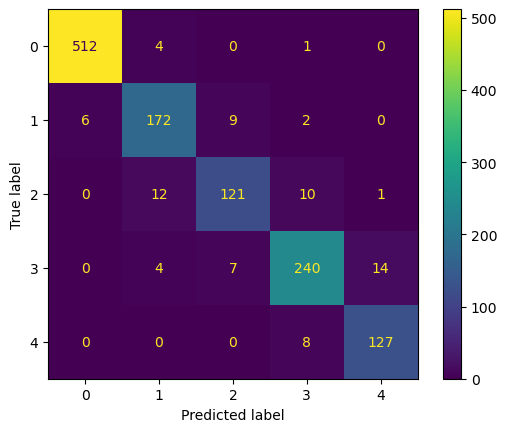

In [20]:
rf_model = RandomForestClassifier(n_estimators=100, max_features="auto", random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print(classification_report(y_test,rf_pred))
plot_confusion_matrix(rf_model,X_test,y_test)
plt.show
print(accuracy_score(y_test, rf_pred))

In [ ]:
incidentes.to_csv("../input/train_data_w_IC_EM.csv",  index=False)
teste.to_csv("../input/test_data_w_IC_EM.csv", index=False)

Este foi um cenário apenas para testar se os tipos menos recorrentes ajudam o modelo. Efetuou-se submissão, não parecem ser relevantes